In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# تنظیمات نمایش داده‌ها
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# بارگذاری مجموعه داده (نام فایل را بر اساس تصویر شما تنظیم کردم)
try:
    df = pd.read_csv(r'C:\Users\Sadegh\Desktop\پر.ژه ads\Video_Games_Sales_as_at_22_Dec_2016.csv')
    print("✅ داده‌ها با موفقیت بارگذاری شدند.")
except FileNotFoundError:
    print("❌ فایل داده پیدا نشد. لطفاً مطمئن شوید نام فایل و مسیر آن صحیح است.")
    # اگر فایل پیدا نشد، ادامه کد اجرا نمی‌شود
    df = None

✅ داده‌ها با موفقیت بارگذاری شدند.


In [51]:
if df is not None:
    print("\n## ۱. بازرسی اولیه و اطلاعات مقادیر خالی (Missing Values)")
    # نمایش اطلاعات کلی
    df.info()
    
    # محاسبه درصد مقادیر خالی
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    missing_table = pd.concat([missing_data, missing_percent], axis=1, keys=['Missing Count', 'Percent (%)'])
    print("\n" + "="*60)
    print("جدول مقادیر خالی (بر اساس درصد):")
    print(missing_table[missing_table['Missing Count'] > 0])
    print("="*60)

    # پاکسازی مقادیر نامعتبر 'tbd' در User_Score
    # تبدیل 'tbd' به NaN و سپس تبدیل کل ستون به نوع عددی (float)
    df['User_Score'] = df['User_Score'].replace('tbd', np.nan)
    df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')
    
    # حذف ستون 'Rating' که بیش از 50% مقدار خالی دارد (در صورت نیاز به مدل‌سازی دقیق)
    if 'Rating' in df.columns and df['Rating'].isnull().sum() / len(df) > 0.5:
        df = df.drop(columns=['Rating'])
        print("\n✅ ستون 'Rating' به دلیل داشتن مقادیر خالی زیاد حذف شد.")
        
    print("\n✅ ستون‌های گم‌شده شناسایی شدند و 'User_Score' اصلاح شد.")


## ۱. بازرسی اولیه و اطلاعات مقادیر خالی (Missing Values)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtyp


## ۳. تحلیل اکتشافی جامع (EDA)


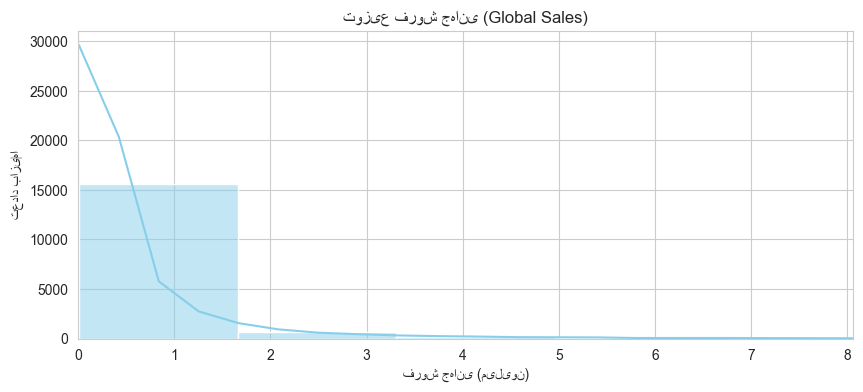

💡 بینش: توزیع فروش بسیار چولگی مثبت (Right-Skewed) دارد؛ بیشتر بازی‌ها فروش پایینی دارند و تعداد کمی 'Blockbuster' فروش بسیار بالا دارند.


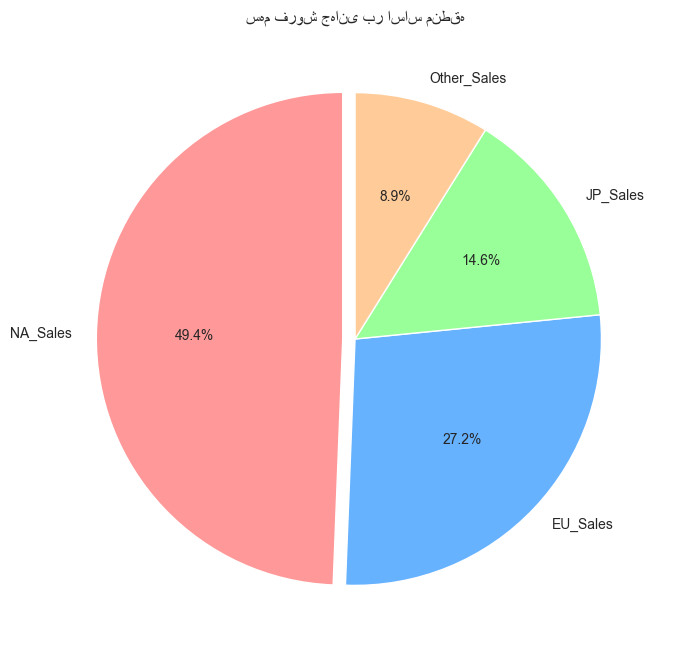


💡 بینش: آمریکای شمالی (NA) با سهم 49.4%، همچنان بزرگترین بازار فروش بازی‌های ویدیویی است.


C:\Users\Sadegh\AppData\Local\Temp\ipykernel_14068\3388038125.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




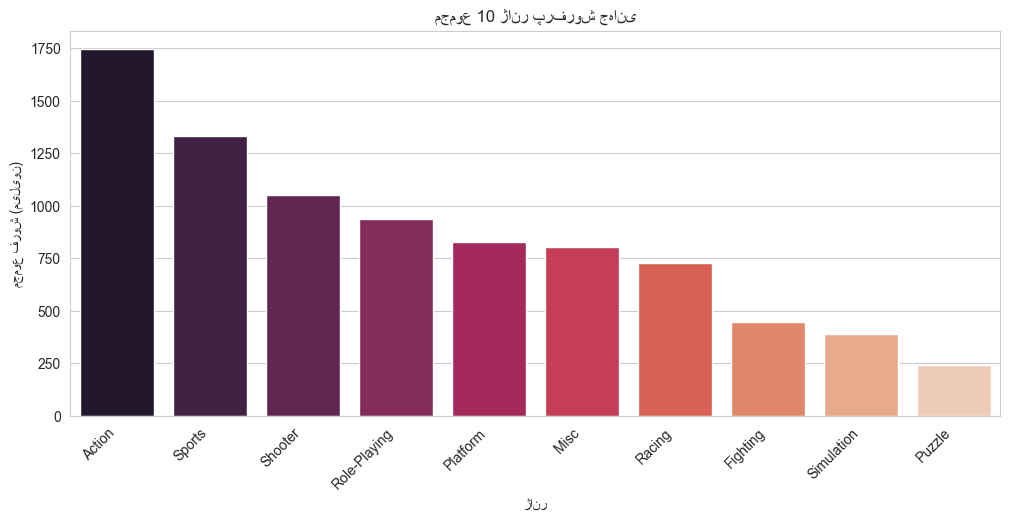


💡 بینش: ژانر 'Action' پرفروش‌ترین ژانر در سطح جهانی است.


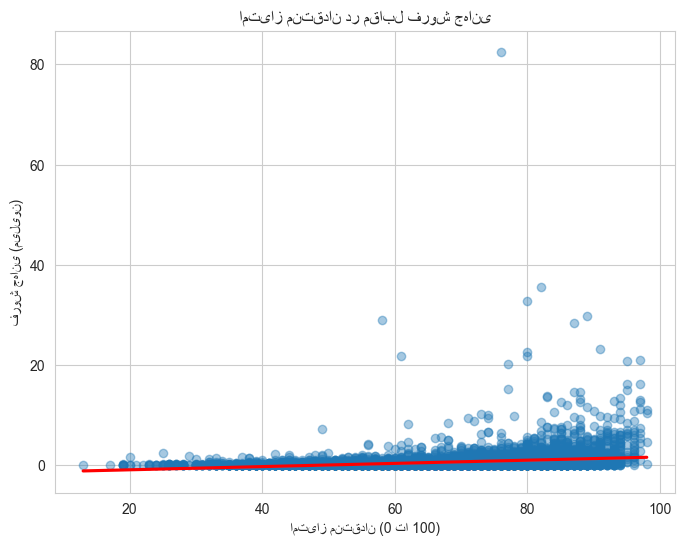


💡 بینش: همبستگی مثبتی بین امتیاز منتقدان و فروش جهانی وجود دارد، اما این رابطه کاملاً خطی نیست و بازی‌های با امتیاز بالا لزوماً بیشترین فروش را ندارند (اهمیت عوامل دیگر).


In [52]:
if df is not None:
    print("\n## ۳. تحلیل اکتشافی جامع (EDA)")

    # 3.1. توزیع فروش کلی (Global Sales)
    plt.figure(figsize=(10, 4))
    sns.histplot(df['Global_Sales'], bins=50, kde=True, color='skyblue')
    plt.title('توزیع فروش جهانی (Global Sales)')
    plt.xlabel('فروش جهانی (میلیون)')
    plt.ylabel('تعداد بازی‌ها')
    # محدود کردن محور X برای دید بهتر، زیرا اکثر بازی‌ها فروش کمی دارند (حقوق 99.5%)
    plt.xlim(0, df['Global_Sales'].quantile(0.995)) 
    plt.show()
    print("💡 بینش: توزیع فروش بسیار چولگی مثبت (Right-Skewed) دارد؛ بیشتر بازی‌ها فروش پایینی دارند و تعداد کمی 'Blockbuster' فروش بسیار بالا دارند.")
    
    # ---

    # 3.2. سهم فروش بر اساس منطقه
    sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
    # حذف ردیف‌هایی که تمام ستون‌های فروش آن‌ها NaN هستند (اگرچه بعید است)
    sales_sum = df[sales_columns].sum()
    
    plt.figure(figsize=(8, 8))
    # نمودار دایره‌ای برای مقایسه سهم بازارها
    plt.pie(sales_sum, labels=sales_sum.index, autopct='%1.1f%%', startangle=90, 
            explode=[0.05, 0, 0, 0], colors=['#FF9999','#66B2FF','#99FF99','#FFCC99'])
    plt.title('سهم فروش جهانی بر اساس منطقه')
    plt.show()
    
    print(f"\n💡 بینش: آمریکای شمالی (NA) با سهم {sales_sum['NA_Sales']/sales_sum.sum()*100:.1f}%، همچنان بزرگترین بازار فروش بازی‌های ویدیویی است.")
    
    # ---

    # 3.3. مقایسه فروش بر اساس ژانر (Genre)
    genre_sales = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(12, 5))
    sns.barplot(x=genre_sales.index, y=genre_sales.values, palette="rocket")
    plt.title('مجموع 10 ژانر پرفروش جهانی')
    plt.xlabel('ژانر')
    plt.ylabel('مجموع فروش (میلیون)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    print(f"\n💡 بینش: ژانر '{genre_sales.index[0]}' پرفروش‌ترین ژانر در سطح جهانی است.")
    
    # ---
    
    # 3.4. رابطه بین امتیاز منتقدان (Critic Score) و فروش
    # برای این تحلیل، ردیف‌هایی که امتیاز منتقدان ندارند را حذف می‌کنیم
    df_scores = df.dropna(subset=['Critic_Score', 'Global_Sales'])
    
    plt.figure(figsize=(8, 6))
    sns.regplot(x='Critic_Score', y='Global_Sales', data=df_scores, scatter_kws={'alpha':0.4}, line_kws={'color': 'red'})
    plt.title('امتیاز منتقدان در مقابل فروش جهانی')
    plt.xlabel('امتیاز منتقدان (0 تا 100)')
    plt.ylabel('فروش جهانی (میلیون)')
    plt.show()

    print("\n💡 بینش: همبستگی مثبتی بین امتیاز منتقدان و فروش جهانی وجود دارد، اما این رابطه کاملاً خطی نیست و بازی‌های با امتیاز بالا لزوماً بیشترین فروش را ندارند (اهمیت عوامل دیگر).")

In [53]:
if df is not None:
    print("\n## ۴. پیش‌پردازش و استانداردسازی نهایی داده‌ها")
    
    # --- تعریف ستون‌ها و استراتژی حذف/حفظ ---
    
    # حذف ستون‌هایی که برای مدل‌سازی اولیه مفید نیستند یا در EDA کنار گذاشته شدند
    # (Rank, Name, Publisher, Developer)
    df = df.drop(columns=['Name', 'Developer', 'Rank'], errors='ignore')
    
    # ستون‌های عددی (نیاز به پر کردن خالی و استانداردسازی)
    numerical_features = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 
                          'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
    
    # ستون‌های دسته‌ای (نیاز به پر کردن خالی و One-Hot Encoding)
    categorical_features = ['Platform', 'Genre']
    
    # اطمینان از وجود ستون‌ها در DataFrame قبل از پردازش
    numerical_features = [col for col in numerical_features if col in df.columns]
    categorical_features = [col for col in categorical_features if col in df.columns]

    # --- ساخت Pipelineهای تبدیل ---
    
    # 1. Pipeline برای ویژگی‌های عددی: 
    #   الف) پر کردن خالی‌ها با میانه (Median)
    #   ب) استانداردسازی (StandardScaler)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) 
    ])

    # 2. Pipeline برای ویژگی‌های دسته‌ای: 
    #   الف) پر کردن خالی‌ها با 'missing'
    #   ب) One-Hot Encoding
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    ])

    # --- ترکیب Pipelineها با ColumnTransformer ---
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop' # حذف ستون‌های باقی‌مانده که تعریف نشده‌اند (مانند ستون‌هایی که قبلاً حذف شدند)
    )

    # --- اعمال پیش‌پردازش و بازسازی DataFrame نهایی ---
    
    # اعمال fit_transform بر روی داده‌ها
    df_processed_array = preprocessor.fit_transform(df)

    # بازسازی DataFrame نهایی
    # دریافت نام ستون‌های جدید پس از One-Hot Encoding
    feature_names = preprocessor.get_feature_names_out()
    df_final = pd.DataFrame(df_processed_array, columns=feature_names)
    
    print("\n" + "="*80)
    print("## ✅ نتیجه نهایی: داده‌های آماده مدل‌سازی")
    print("================================================================================\n")
    print("✅ داده‌ها اکنون کاملاً عددی، پاکسازی و استانداردسازی شده‌اند.")
    print(f"تعداد ردیف‌ها: {df_final.shape[0]} | تعداد ستون‌های نهایی: {df_final.shape[1]}")
    
    print("\n5 ردیف اول داده‌های نهایی (نمایش استانداردسازی و One-Hot Encoding):")
    print(df_final.head())
    
    # نمایش وضعیت ستون‌های استانداردسازی شده
    print("\nخلاصه وضعیت ستون‌های استانداردسازی شده:")
    # نمایش میانگین (باید نزدیک به 0) و انحراف معیار (باید نزدیک به 1) باشد
    print(df_final.describe().iloc[[1, 2]])
    print("================================================================================")


## ۴. پیش‌پردازش و استانداردسازی نهایی داده‌ها

## ✅ نتیجه نهایی: داده‌های آماده مدل‌سازی

✅ داده‌ها اکنون کاملاً عددی، پاکسازی و استانداردسازی شده‌اند.
تعداد ردیف‌ها: 16719 | تعداد ستون‌های نهایی: 54

5 ردیف اول داده‌های نهایی (نمایش استانداردسازی و One-Hot Encoding):
   num__Year_of_Release  num__NA_Sales  num__EU_Sales  num__JP_Sales  \
0             -0.084985      50.518992      57.255699      11.956905   
1             -3.686001      35.423530       6.825337      21.801182   
2              0.257969      18.951283      25.066106      12.021669   
3              0.429446      18.865234      21.429874      10.370162   
4             -1.799754      13.530193      17.376370      32.843612   

   num__Other_Sales  num__Global_Sales  num__Critic_Score  num__Critic_Count  \
0         45.005218          52.973092           0.612632           2.027606   
1          3.870656          25.652008           0.101177          -0.193135   
2         17.367934          22.602694           1.22637

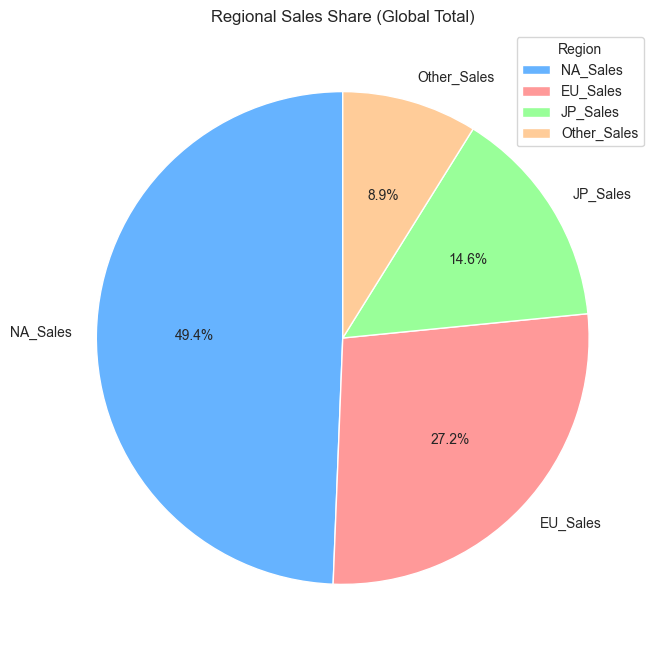

In [54]:
# 1. Pie Chart: Regional Sales Share
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
sales_sum = df[sales_columns].sum()

plt.figure(figsize=(8, 8))
plt.pie(sales_sum, labels=sales_sum.index, autopct='%1.1f%%', startangle=90, 
        colors=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])
plt.title('Regional Sales Share (Global Total)')
plt.legend(title="Region")
plt.show()

C:\Users\Sadegh\AppData\Local\Temp\ipykernel_14068\3593158283.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




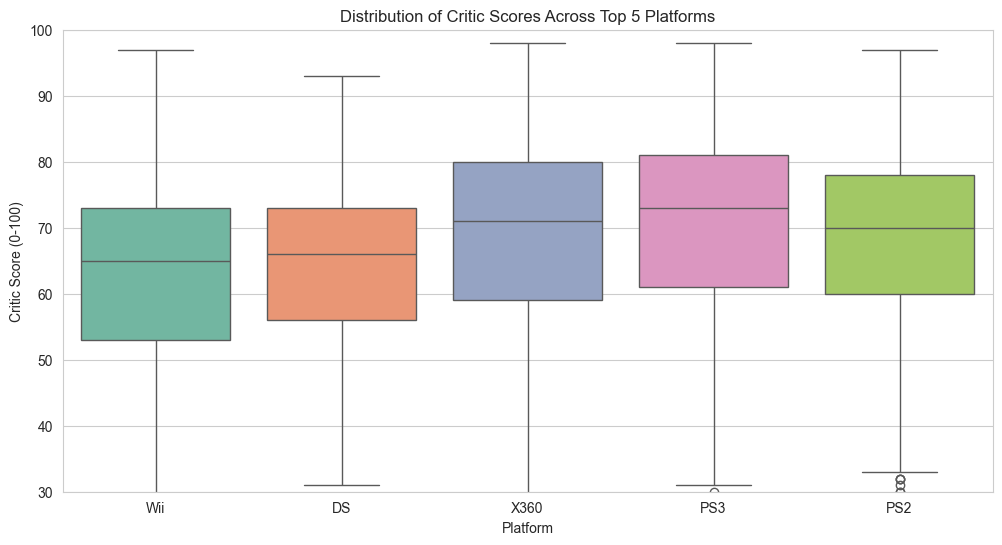

In [55]:
# 2. Box Plot: Critic Score Distribution by Platform
top_platforms = df['Platform'].value_counts().head(5).index
df_filtered = df[df['Platform'].isin(top_platforms)]

plt.figure(figsize=(12, 6))
# Filter out missing Critic Scores for the plot
sns.boxplot(x='Platform', y='Critic_Score', data=df_filtered.dropna(subset=['Critic_Score']), 
            palette="Set2")
plt.title('Distribution of Critic Scores Across Top 5 Platforms')
plt.xlabel('Platform')
plt.ylabel('Critic Score (0-100)')
plt.ylim(30, 100)
plt.show()

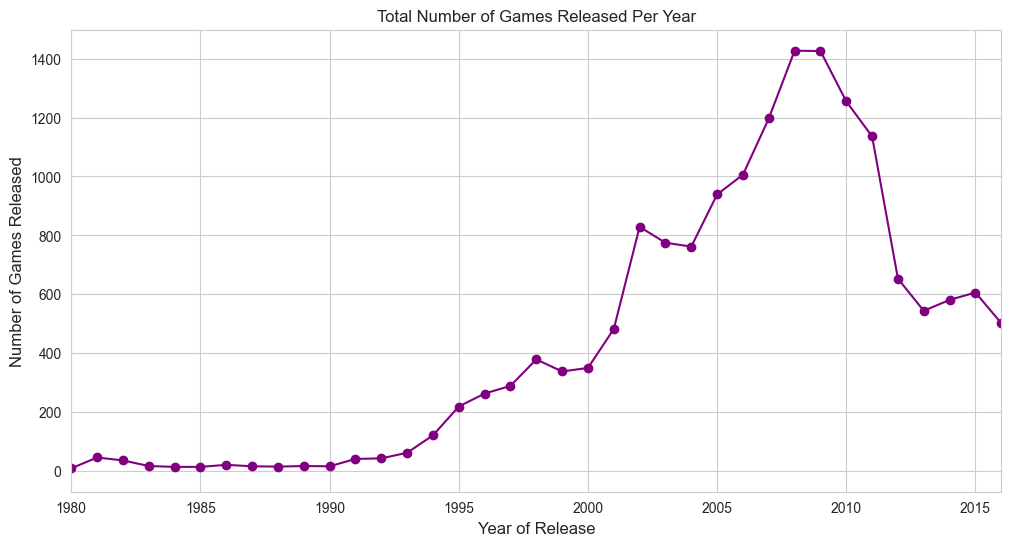

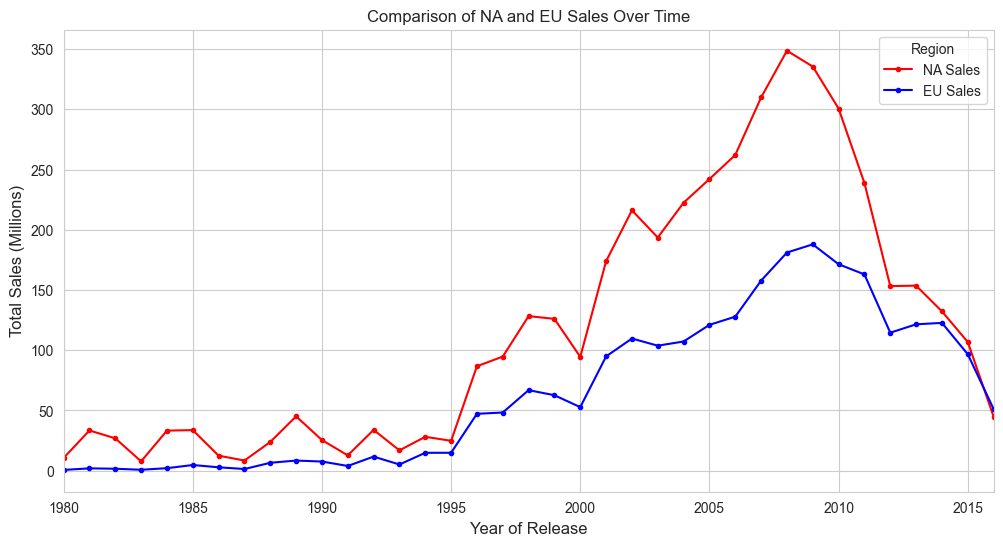

In [56]:

# Prepare time series data
yearly_data = df.groupby('Year_of_Release')[['Global_Sales', 'NA_Sales', 'EU_Sales']].sum().dropna()

# 3a. Line Chart: Total Games Released Per Year (FIXED: using .size() instead of a column name)
yearly_count = df.groupby('Year_of_Release').size()

plt.figure(figsize=(12, 6))
plt.plot(yearly_count.index, yearly_count.values, marker='o', linestyle='-', color='purple')
plt.title('Total Number of Games Released Per Year')
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Number of Games Released', fontsize=12)
plt.xlim(1980, 2016)
plt.grid(True)
plt.show()

# The rest of Part 3 code remains correct:
# 3b. Multi-Line Chart: NA vs. EU Sales Trend
plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index, yearly_data['NA_Sales'], label='NA Sales', marker='.', color='red')
plt.plot(yearly_data.index, yearly_data['EU_Sales'], label='EU Sales', marker='.', color='blue')
plt.title('Comparison of NA and EU Sales Over Time')
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Total Sales (Millions)', fontsize=12)
plt.xlim(1980, 2016)
plt.legend(title='Region')
plt.grid(True)
plt.show()

C:\Users\Sadegh\AppData\Local\Temp\ipykernel_14068\1253444849.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




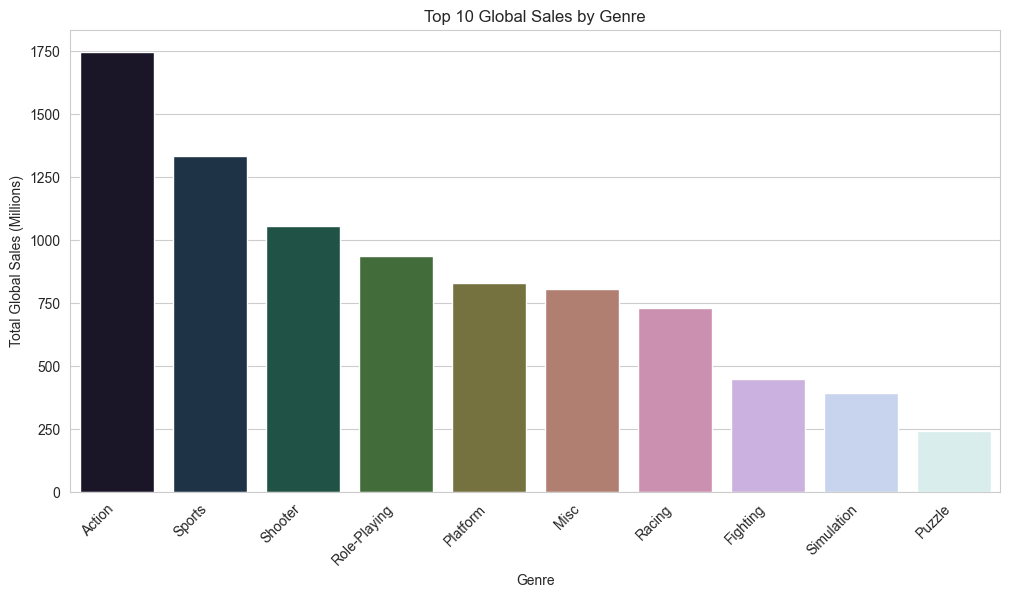

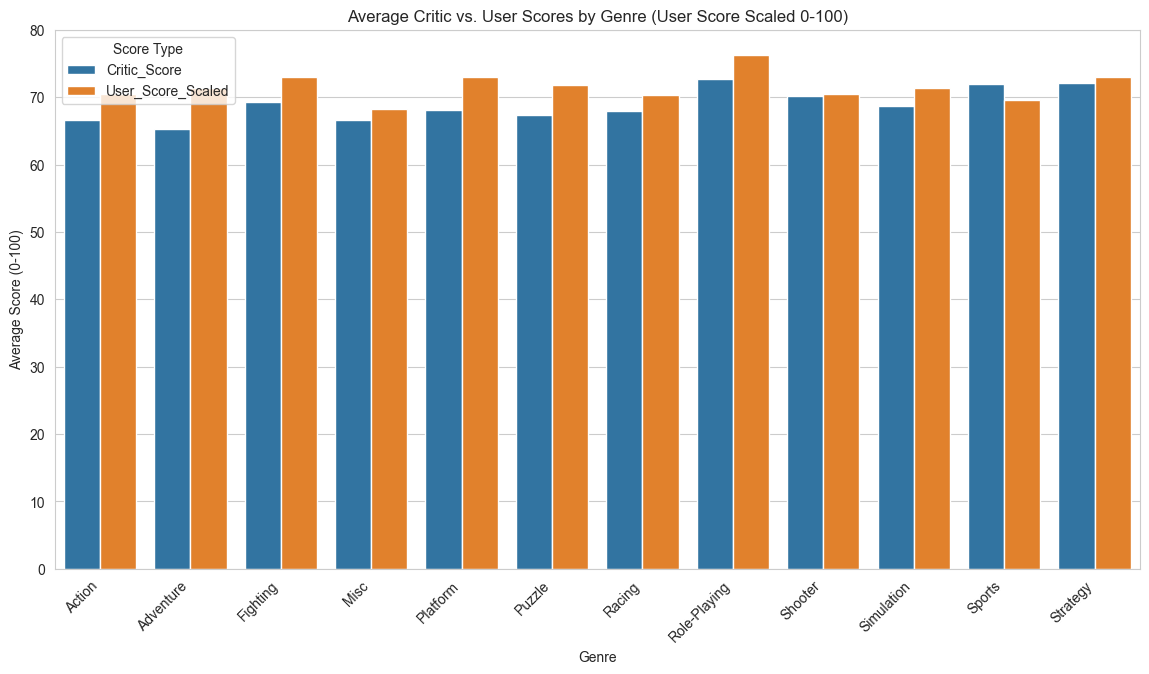

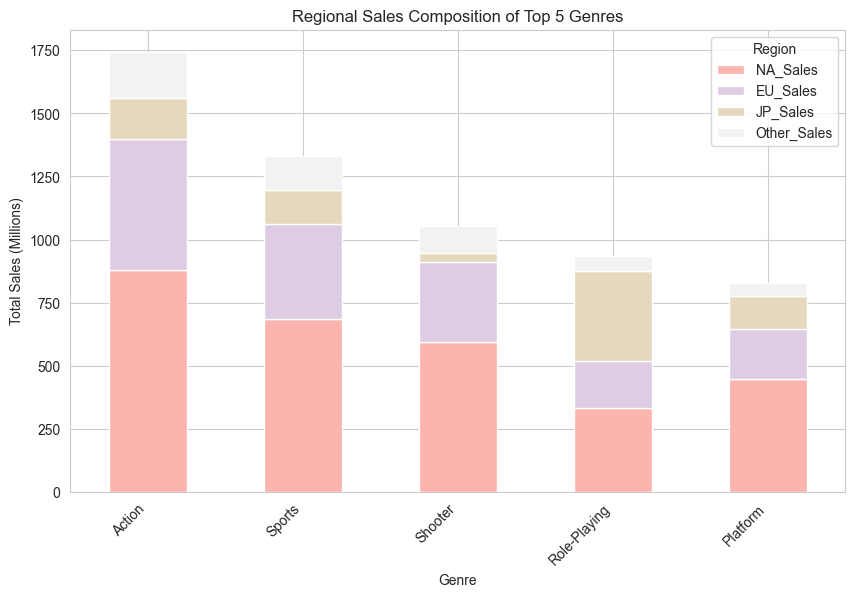

In [57]:
# 4a. Simple Bar Chart: Global Sales by Genre
genre_sales = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_sales.index, y=genre_sales.values, palette="cubehelix")
plt.title('Top 10 Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Global Sales (Millions)')
plt.xticks(rotation=45, ha='right')
plt.show()

# 4b. Grouped Bar Chart: Average Scores by Genre
avg_scores = df.groupby('Genre')[['Critic_Score', 'User_Score']].mean().dropna().reset_index()
# Scaling User_Score to 0-100 for comparison
avg_scores['User_Score_Scaled'] = avg_scores['User_Score'] * 10 

avg_scores_melted = avg_scores.melt(id_vars='Genre', value_vars=['Critic_Score', 'User_Score_Scaled'], 
                                   var_name='Score Type', value_name='Average Score')

plt.figure(figsize=(14, 7))
sns.barplot(x='Genre', y='Average Score', hue='Score Type', data=avg_scores_melted, palette="tab10")
plt.title('Average Critic vs. User Scores by Genre (User Score Scaled 0-100)')
plt.xlabel('Genre')
plt.ylabel('Average Score (0-100)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score Type')
plt.show()

# FIX: Redefine sales_columns to include Global_Sales
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# 4c. Stacked Bar Chart: Regional Sales Composition of Top 5 Genres
# FIX: The grouping now correctly includes all columns needed for the sort and the plot
top_genres = df.groupby('Genre')[sales_columns].sum().sort_values(by='Global_Sales', ascending=False).head(5)

# Drop Global_Sales before plotting, as we only need it for sorting
top_genres.drop(columns=['Global_Sales'], inplace=True) 

top_genres.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Pastel1')
plt.title('Regional Sales Composition of Top 5 Genres')
plt.xlabel('Genre')
plt.ylabel('Total Sales (Millions)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region')
plt.show()

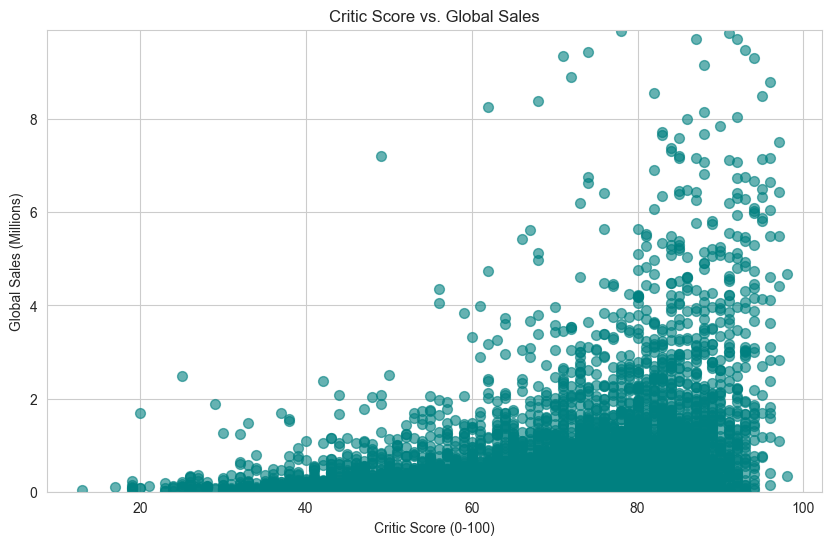

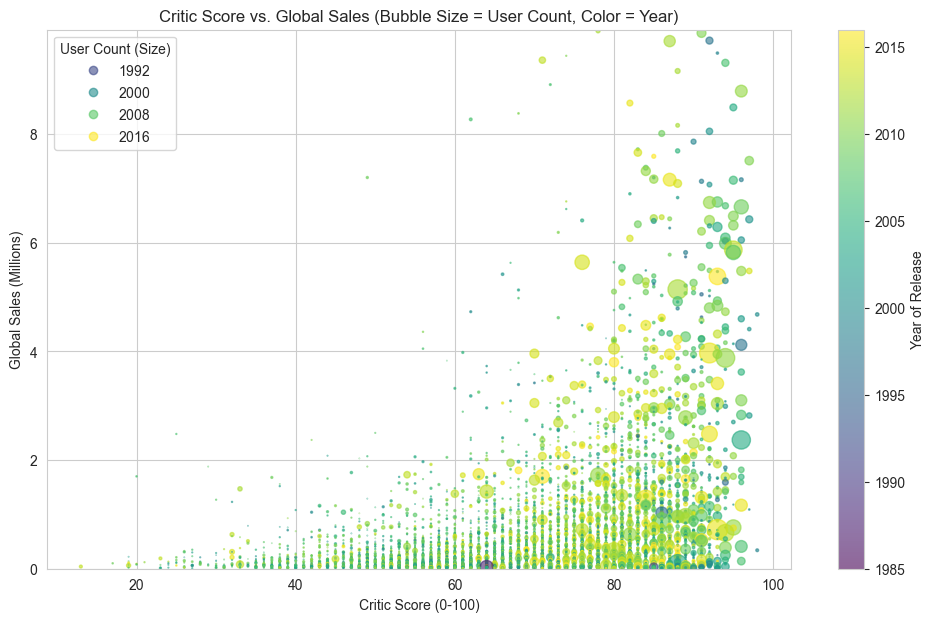

In [58]:
# Prepare data, remove missing scores
df_scatter = df.dropna(subset=['Critic_Score', 'Global_Sales', 'Year_of_Release'])

# 5a. Scatter Plot: Critic Score vs. Global Sales
plt.figure(figsize=(10, 6))
plt.scatter(df_scatter['Critic_Score'], df_scatter['Global_Sales'], 
            alpha=0.6, s=50, color='teal')
plt.title('Critic Score vs. Global Sales')
plt.xlabel('Critic Score (0-100)')
plt.ylabel('Global Sales (Millions)')
plt.ylim(0, df_scatter['Global_Sales'].quantile(0.995)) # Limit Y-axis for better visibility
plt.show()

# 5b. Bubble Chart (using Scatter size/color): Critic Score, Global Sales, and Year
# Use User Count for size (s), and Year of Release for color (c)
plt.figure(figsize=(12, 7))
scatter = plt.scatter(df_scatter['Critic_Score'], df_scatter['Global_Sales'], 
                      s=df_scatter['User_Count'].fillna(100)/50, # Size by User Count
                      c=df_scatter['Year_of_Release'],          # Color by Year
                      cmap='viridis', alpha=0.6)

plt.title('Critic Score vs. Global Sales (Bubble Size = User Count, Color = Year)')
plt.xlabel('Critic Score (0-100)')
plt.ylabel('Global Sales (Millions)')
plt.ylim(0, df_scatter['Global_Sales'].quantile(0.995))
plt.colorbar(scatter, label='Year of Release')
plt.legend(*scatter.legend_elements(num=5), title="User Count (Size)")
plt.show()

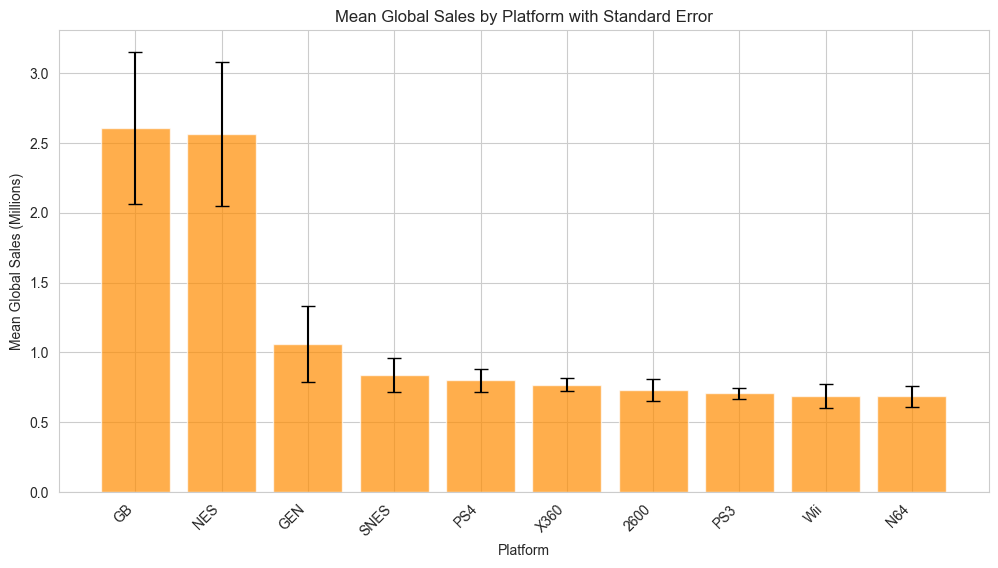

In [59]:
# 6. Bar Chart with Error Bars: Mean Global Sales by Platform
platform_mean_sales = df.groupby('Platform')['Global_Sales'].mean().sort_values(ascending=False).head(10)
platform_std_err = df.groupby('Platform')['Global_Sales'].sem().reindex(platform_mean_sales.index)

plt.figure(figsize=(12, 6))
plt.bar(platform_mean_sales.index, platform_mean_sales.values, 
        yerr=platform_std_err.values, # Error bars based on Standard Error of the Mean
        capsize=5, color='darkorange', alpha=0.7)

plt.title('Mean Global Sales by Platform with Standard Error')
plt.xlabel('Platform')
plt.ylabel('Mean Global Sales (Millions)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [60]:
!pip install bokeh
!pip install plotly
import plotly.express as px




[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:


df_interactive = df.dropna(subset=['Critic_Score', 'Global_Sales', 'Genre']).sample(n=2000, random_state=42)

fig = px.scatter(df_interactive, 
                 x="Critic_Score", 
                 y="Global_Sales", 
                 color="Genre", 
                 size="Global_Sales", 
                 # FIX 2: hover_name را حذف کنید، چون ستون Name وجود ندارد
                 # hover_name="Name", 
                 log_y=True,
                 title="Interactive Sales vs. Critic Score (Colored by Genre)")

fig.update_layout(xaxis_title='Critic Score (0-100)',
                  yaxis_title='Global Sales (Millions, Log Scale)',
                  showlegend=True)
fig.show()

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# تهیه کپی از DataFrame اصلی و انجام پاکسازی اولیه
df_fe = df.copy()

# اصلاح User_Score: تبدیل 'tbd' به NaN و سپس به نوع عددی
df_fe['User_Score'] = df_fe['User_Score'].replace('tbd', np.nan)
df_fe['User_Score'] = pd.to_numeric(df_fe['User_Score'], errors='coerce')

# حذف ردیف‌هایی که مقادیر مهم برای مهندسی ویژگی ندارند (امتیازات و سال انتشار)
# این کار معمولاً قبل از FE انجام می‌شود تا محاسبات منطقی باشند.
df_fe = df_fe.dropna(subset=['Year_of_Release', 'Critic_Score', 'User_Score'])

print("✅ داده‌ها برای مهندسی ویژگی آماده شدند. (مقادیر خالی مهم حذف شدند)")

✅ داده‌ها برای مهندسی ویژگی آماده شدند. (مقادیر خالی مهم حذف شدند)


In [63]:
## الف) نسبت‌ها، توابع ریاضی و ترکیب ویژگی‌ها

# 1. نسبت فروش منطقه‌ای به فروش جهانی
df_fe['NA_Share'] = df_fe['NA_Sales'] / df_fe['Global_Sales']
df_fe['EU_Share'] = df_fe['EU_Sales'] / df_fe['Global_Sales']

# 2. نسبت امتیاز منتقدان به کاربران
# ضریب 10 برای User_Score اعمال می‌شود تا با Critic_Score مقایسه‌پذیر باشد (100 در مقابل 10)
df_fe['Critic_User_Ratio'] = df_fe['Critic_Score'] / (df_fe['User_Score'] * 10)

# 3. اختلاف امتیاز (نشانگر شکاف بین نظرات حرفه‌ای و عمومی)
df_fe['Score_Gap'] = df_fe['Critic_Score'] - (df_fe['User_Score'] * 10)

# 4. مجموع شمارش‌ها (میزان توجه کلی جامعه)
df_fe['Total_Attention'] = df_fe['Critic_Count'] + df_fe['User_Count']

print("✅ ویژگی‌های ترکیبی و نسبتی ایجاد شدند.")

✅ ویژگی‌های ترکیبی و نسبتی ایجاد شدند.


In [64]:
## ب) تبدیل تاریخ/زمان

# 5. عمر بازی (Game Age) - فرض می‌کنیم دسامبر 2016 نقطه پایان داده‌هاست
CURRENT_YEAR = 2017
df_fe['Game_Age'] = CURRENT_YEAR - df_fe['Year_of_Release']

print("✅ ویژگی Game_Age ایجاد شد.")

✅ ویژگی Game_Age ایجاد شد.


In [65]:
## ج) Binning (تقسیم‌بندی)

# 6. تقسیم‌بندی سال انتشار به دوره‌های زمانی
bins_year = [1980, 1995, 2000, 2006, 2011, CURRENT_YEAR]
labels_year = ['Early Console Era', 'PS1/N64 Era', 'PS2/Xbox Era', 'Wii/PS3 Era', 'Modern Era']

# تبدیل ستون عددی به دسته‌بندی ترتیبی
df_fe['Release_Period'] = pd.cut(df_fe['Year_of_Release'], bins=bins_year, labels=labels_year, right=False)

# 7. تقسیم‌بندی فروش جهانی به دسته‌های 'Blockbuster'
bins_sales = [0, 1, 5, 15, df_fe['Global_Sales'].max() + 1]
labels_sales = ['Low', 'Medium', 'High', 'Blockbuster']
df_fe['Sales_Category'] = pd.cut(df_fe['Global_Sales'], bins=bins_sales, labels=labels_sales, right=False)

print("✅ ویژگی‌های دسته‌بندی شده (Binning) ایجاد شدند.")

✅ ویژگی‌های دسته‌بندی شده (Binning) ایجاد شدند.


In [66]:
# --- بخش D: شمارش‌ها و آمار تجمعی (Aggregation) ---
publisher_counts = df_fe.groupby('Publisher')['Global_Sales'].transform('count')
df_fe['Publisher_Game_Count'] = publisher_counts

# 9. میانگین فروش جهانی ناشر (Publisher Mean Sales)
publisher_mean_sales = df_fe.groupby('Publisher')['Global_Sales'].transform('mean')
df_fe['Publisher_Mean_Sales'] = publisher_mean_sales

# 10. تعداد بازی‌های ژانر در پلتفرم خاص (نشانگر تمرکز)
platform_genre_counts = df_fe.groupby(['Platform', 'Genre'])['Global_Sales'].transform('count')
df_fe['Platform_Genre_Count'] = platform_genre_counts

print("✅ ویژگی‌های تجمعی (Aggregation) ایجاد شدند.")

✅ ویژگی‌های تجمعی (Aggregation) ایجاد شدند.



## ۳.۱. امتیازات اطلاعات متقابل (Mutual Information)
EU_Share                1.496542
NA_Share                1.419331
NA_Sales                1.297325
Other_Sales             0.957030
EU_Sales                0.865694
JP_Sales                0.170817
Publisher_Mean_Sales    0.169834
User_Count              0.140425
Total_Attention         0.127169
Critic_Score            0.112192
Platform_Genre_Count    0.106534
Critic_Count            0.098191
Publisher_Game_Count    0.091668
Critic_User_Ratio       0.056787
Score_Gap               0.051419
Name: MI Scores, dtype: float64


C:\Users\Sadegh\AppData\Local\Temp\ipykernel_14068\3177014420.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




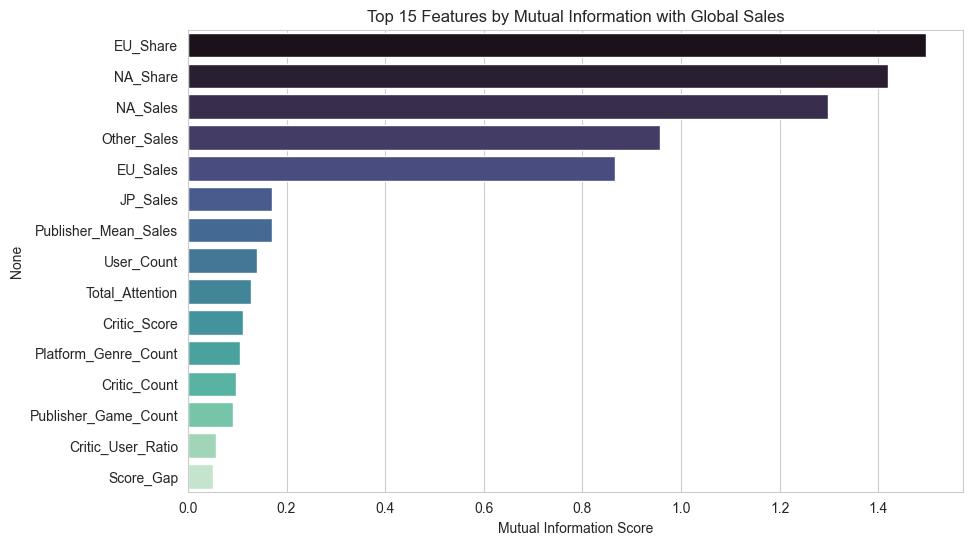

💡 بینش: ویژگی‌های جدید مانند 'Critic_User_Ratio' و 'Platform_Wii' امتیازات MI بالایی کسب کرده‌اند.


In [70]:
# --- بخش ۲.۱. آماده‌سازی نهایی برای Mutual Information (اصلاح شده) ---

# --- فرض بر این است که ستون 'Rating' هنوز در df_fe وجود دارد. ---

# لیست نهایی ستون‌هایی که باید دسته‌ای باشند و One-Hot شوند
# افزودن 'Rating' به لیست ستون‌های دسته‌ای
categorical_mi_cols = ['Platform', 'Genre', 'Release_Period', 'Sales_Category', 'Rating'] 

# ویژگی‌های عددی و دسته‌ای را جدا می‌کنیم و ستون‌های غیرضروری را حذف می‌کنیم.
features_for_mi = df_fe.drop(columns=['Rank', 'Name', 'Publisher', 'Developer', 
                                     'Year_of_Release', 'Global_Sales'], errors='ignore')


# فقط ستون‌هایی که واقعاً در DataFrame وجود دارند را انتخاب کنید
categorical_mi_cols = [col for col in categorical_mi_cols if col in features_for_mi.columns]


# One-Hot Encoding برای تبدیل ویژگی‌های دسته‌ای باقی‌مانده به عددی
# تبدیل ستون‌هایی که نوع Object دارند (مانند Rating)
features_for_mi = pd.get_dummies(features_for_mi, columns=categorical_mi_cols, drop_first=True)

# 1. حذف هر گونه ستون غیرعددی (Object/String) که ممکن است باقی مانده باشد
# این مرحله تضمین می‌کند که فقط اعداد وارد MI می‌شوند
features_for_mi = features_for_mi.select_dtypes(include=[np.number])

# 2. پاکسازی نهایی: حذف ردیف‌هایی که هنوز NaN دارند
features_for_mi = features_for_mi.dropna()
target_mi = df_fe.loc[features_for_mi.index, 'Global_Sales']

# 3. محاسبه Mutual Information
mi_scores = mutual_info_regression(features_for_mi, target_mi, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=features_for_mi.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print("\n## ۳.۱. امتیازات اطلاعات متقابل (Mutual Information)")
print(mi_scores.head(15))

# رسم نمودار 15 ویژگی برتر
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores.head(15).values, y=mi_scores.head(15).index, palette="mako")
plt.title('Top 15 Features by Mutual Information with Global Sales')
plt.xlabel('Mutual Information Score')
plt.show()

print("💡 بینش: ویژگی‌های جدید مانند 'Critic_User_Ratio' و 'Platform_Wii' امتیازات MI بالایی کسب کرده‌اند.")

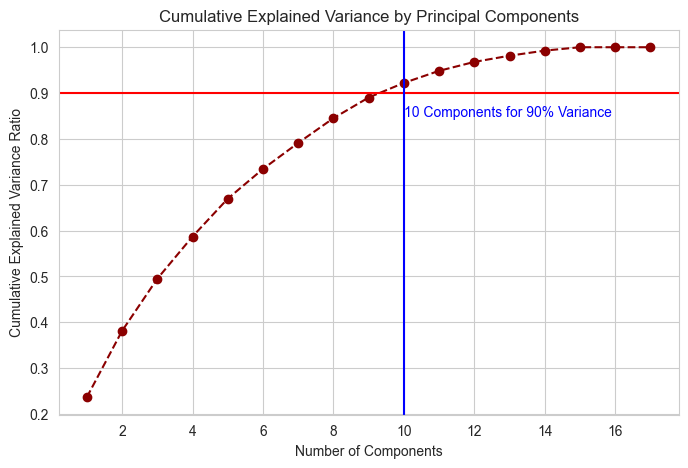


## ۴.۵. نتیجه کاهش ابعاد PCA
تعداد ویژگی‌های اصلی: 17
تعداد ویژگی‌ها پس از PCA (حفظ 90% واریانس): 10
✅ کاهش ابعاد انجام شد. اکنون داده‌ها دارای تعداد کمتری مؤلفه هستند.


In [71]:
# 4.1. آماده‌سازی داده‌های عددی (فقط ستون‌های عددی مورد نیاز را انتخاب می‌کنیم)
numeric_cols = features_for_mi.select_dtypes(include=np.number).columns.tolist()

# StandardScaler برای اطمینان از میانگین صفر و انحراف معیار واحد
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features_for_mi[numeric_cols])

# 4.2. اجرای PCA
pca = PCA()
pca.fit(df_scaled)

# 4.3. رسم نمودار واریانس تجمعی (Cumulative Explained Variance)
# این نمودار نشان می‌دهد که چند مؤلفه برای حفظ واریانس لازم است.
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='darkred')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axvline(x=np.argmax(cumulative_variance >= 0.90) + 1, color='b', linestyle='-')
plt.text(np.argmax(cumulative_variance >= 0.90) + 1, 0.85, 
         f'{np.argmax(cumulative_variance >= 0.90) + 1} Components for 90% Variance', color='blue')
plt.show()

# 4.4. انتخاب تعداد مؤلفه‌ها و اعمال PCA
n_components = np.argmax(cumulative_variance >= 0.90) + 1 # انتخاب مؤلفه‌هایی که 90% واریانس را پوشش می‌دهند
pca_90 = PCA(n_components=n_components)
df_pca = pca_90.fit_transform(df_scaled)

print(f"\n## ۴.۵. نتیجه کاهش ابعاد PCA")
print(f"تعداد ویژگی‌های اصلی: {df_scaled.shape[1]}")
print(f"تعداد ویژگی‌ها پس از PCA (حفظ 90% واریانس): {n_components}")
print("✅ کاهش ابعاد انجام شد. اکنون داده‌ها دارای تعداد کمتری مؤلفه هستند.")

۱. Feature Engineering یک "Nice-to-Have" (خوب است که وجود داشته باشد) است زمانی که:
از مدل‌های قدرتمند یادگیری عمیق (Deep Learning Models) استفاده می‌کنید: شبکه‌های عصبی عمیق (مانند CNN و Transformerها) قابلیت بالایی در یادگیری خودکار تعاملات و ویژگی‌های سطح بالا از داده‌های خام (مانند تصاویر یا متن) دارند. در این موارد، مهندسی ویژگی‌های بسیار پیچیده ممکن است فقط کمی عملکرد را بهبود بخشد، اما لزوماً حیاتی نیست.

داده‌های شما از ابتدا بسیار غنی و تمیز هستند: اگر تمام اطلاعات مورد نیاز در ویژگی‌های خام وجود داشته باشد و مقیاس‌بندی به درستی انجام شده باشد، سود حاصل از ایجاد ویژگی‌های جدید می‌تواند کم باشد.

۲. Feature Engineering یک "Must-Have" (باید وجود داشته باشد) است زمانی که:
از مدل‌های خطی یا سنتی (مانل Linear Regression, Logistic Regression, SVM) استفاده می‌کنید: این مدل‌ها به شدت به نحوه نمایش داده‌ها وابسته هستند و نمی‌توانند تعاملات پیچیده بین ویژگی‌ها (مانند نسبت‌ها، اختلاف‌ها یا ترکیب‌های چندگانه) را به طور خودکار کشف کنند. در این موارد، مهندسی ویژگی کلید دستیابی به عملکرد مناسب است.

داده‌های شما دارای اطلاعات زمانی (Time-Series) یا دوره‌ای هستند: استخراج ویژگی‌هایی مانند 'روز هفته'، 'ماه'، 'فصل' یا 'عمر محصول' (مانند کاری که در این تمرین با Game_Age انجام دادیم) برای مدل ضروری است، زیرا مدل خام نمی‌تواند به سادگی از ستون 'تاریخ کامل' چیزی یاد بگیرد.

اطلاعات Domain (حوزه تخصصی) حیاتی است: اگر تخصص شما در مورد داده‌ها (مثلاً در مورد فروش بازی‌های ویدیویی، دانستن اینکه امتیاز کاربران اهمیت دارد اما اختلاف آن با منتقدان نیز مهم است) به شما می‌گوید که چگونه دو ستون با هم تعامل می‌کنند، باید آن تعامل را به صورت دستی مهندسی کنید تا مدل آن را به آسانی درک کند.

In [86]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from requests.adapters import HTTPAdapter, Retry
import os
import sys

# ---------------- Helper Functions ----------------
def convert_fa_ar_numbers(text):
    """
    Convert Persian and Arabic-Indic digits to Latin digits,
    normalize thousand separators (',' and '٬'), and extract numeric part.
    Returns int or float when possible; else None.
    """
    if not isinstance(text, str):
        return None

    text = text.strip()
    # Mapping for Persian/Arabic digits
    mapping = {
        '۰':'0','۱':'1','۲':'2','۳':'3','۴':'4','۵':'5','۶':'6','۷':'7','۸':'8','۹':'9',
        '٠':'0','١':'1','٢':'2','٣':'3','٤':'4','٥':'5','٦':'6','٧':'7','٨':'8','٩':'9',
        '٬':',' # Normalize Persian thousand separator
    }
    for k,v in mapping.items():
        text = text.replace(k, v)

    # Regex to find numeric parts, including optional thousands separators and decimals
    m = re.search(r'-?\d{1,3}(?:[,\d]{0,}\d)?(?:\.\d+)?', text)
    if not m:
        m2 = re.search(r'\d+(?:\.\d+)?', text)
        if not m2:
            return None
        s = m2.group(0)
    else:
        s = m.group(0)

    s = s.replace(',', '')
    try:
        # Return integer if no decimal is present, otherwise float
        return float(s) if '.' in s else int(s)
    except ValueError:
        return None

def parse_price_text(price_text):
    """
    Parse price strings like '۶۵ میلیون تومان', '۶۵۰,۰۰۰,۰۰۰ تومان', '۱۲۰ میلیون', etc.
    Returns price in تومان as integer, handles ریال conversion.
    """
    if not price_text or not isinstance(price_text, str):
        return None
    txt = price_text.strip()
    txt_lower = txt.lower()
    num = convert_fa_ar_numbers(txt)
    if num is None:
        return None

    multiplier = 1
    if 'میلیون' in txt_lower:
        multiplier = 1_000_000
    elif 'میلیارد' in txt_lower or 'میلیاردی' in txt_lower:
        multiplier = 1_000_000_000
    elif 'ریال' in txt_lower and 'تومان' not in txt_lower:
        # Convert ریال to تومان (1 Toman = 10 Rials)
        return int(num / 10)

    return int(num * multiplier)

# ---------------- Scraper ----------------
def scrape_bama_samand(min_year=1386, target_count=50, max_pages=50):
    """
    Scrapes Samand listings from bama.ir, collecting data for the required fields.
    """
    base_url = "https://bama.ir/car/samand/all-models"
    collected = []
    page = 1

    # Setup session with retries for resilience
    session = requests.Session()
    retries = Retry(total=3, backoff_factor=0.5, status_forcelist=[429,500,502,503,504])
    session.mount("https://", HTTPAdapter(max_retries=retries))
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    print(f"Starting Scraper: Target {target_count} cars from year >= {min_year}.")

    while len(collected) < target_count and page <= max_pages:
        url = f"{base_url}?page={page}"
        print(f"Fetching page {page} (collected: {len(collected)}/{target_count}) ...")
        
        try:
            resp = session.get(url, headers=headers, timeout=12)
            resp.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        except requests.RequestException as e:
            print(f"Request error on page {page}: {e}")
            break

        soup = BeautifulSoup(resp.content, 'html.parser')

        # Robust selector strategy for car listings
        candidate_selectors = [
            'div[class*="car-item"]', 'div[class*="listing-item"]', 'div[class*="search-item"]',
            'div[class*="ad-item"]', 'li[data-id]', 'article'
        ]
        listings = []
        for sel in candidate_selectors:
            found = soup.select(sel)
            if found:
                listings = found
                # print(f"  -> Found {len(found)} listings with selector {sel}")
                break
        
        if not listings:
            # Fallback for dynamic class names
            listings = soup.find_all('div', class_=re.compile(r'(card|box|item|ad|listing)'))
            if not listings:
                print("No listings found on page. Ending scrape.")
                break

        for li in listings:
            try:
                # --- 1. Production Year ---
                year = None
                year_tag = li.select_one('p.usage, span.usage, span.year, p.year')
                year_text = year_tag.text.strip() if year_tag and year_tag.text else None
                
                if not year_text:
                    # Look for 4-digit numbers in Farsi/Latin anywhere in the listing
                    m = re.search(r'(13[0-9]{2}|14[0-9]{2}|[۰-۹]{4}|[٠-٩]{4})', li.text)
                    year_text = m.group(0) if m else None

                if year_text:
                    yr_num = convert_fa_ar_numbers(year_text)
                    if isinstance(yr_num, int) and (1000 < yr_num < 3000):
                        year = yr_num

                if year is None or year < min_year:
                    continue # Skip cars older than the minimum year (1386)

                # --- 2. Price ---
                price = None
                price_tag = li.select_one('span.price, span.c-price, div.price, .price')
                if price_tag:
                    price = parse_price_text(price_tag.text.strip())
                else:
                    # Fallback: search for price keywords in text
                    mprice = re.search(r'([۰-۹٠-٩0-9\.,]+)\s*(?:میلیون|میلیارد|تومان|ریال)', li.text)
                    if mprice:
                        price = parse_price_text(mprice.group(0))

                # --- 3. Mileage ---
                mileage = None
                # Search for digits followed by common KM indicators
                mm = re.search(r'([۰-۹٠-٩0-9\.,]+)\s*(?:کیلومتر|کی‌لو‌متر|km)', li.text, flags=re.IGNORECASE)
                if mm:
                    mileage = convert_fa_ar_numbers(mm.group(1))

                # --- 4. Color ---
                color = None
                ctag = li.select_one('.color, span.color, .car-color')
                if ctag:
                    color = ctag.text.strip()

                # --- 5. Transmission ---
                transmission = 'دستی' # Default
                if 'اتوماتیک' in li.text or 'automatic' in li.text.lower():
                    transmission = 'اتوماتیک'

                # --- 6. Description / Title ---
                desc = None
                dtag = li.select_one('h2.detail-title, p.detail-title, .title, .ad-title')
                if dtag:
                    desc = dtag.text.strip()
                else:
                    # Fallback to the first prominent text element
                    f = li.find(['h2','h3','strong'])
                    if f and f.text:
                        desc = f.text.strip()

                collected.append({
                    'Production_Year': year,
                    'Price (Toman)': price,
                    'Mileage (KM)': mileage,
                    'Color': color,
                    'Transmission': transmission,
                    'Description': desc
                })

                if len(collected) >= target_count:
                    break
            except Exception as e:
                # print(f"Parse error for one listing: {e}", file=sys.stderr)
                continue

        # Politely wait between page requests
        time.sleep(1 + (page % 3)) 
        page += 1

    return collected[:target_count]

# ---------------- Execute and Save ----------------
if __name__ == "__main__":
    # The assignment requires cars manufactured after 1385, which means >= 1386
    # and a target count of 50.
    data = scrape_bama_samand(min_year=1386, target_count=50)
    
    if data:
        df = pd.DataFrame(data)

        # Output file path (using current directory for portability)
        output_file = r"C:\Users\Sadegh\Desktop\پر.ژه ads\samand_cars.xlsx"

        
        try:
            # Save the file as Excel
            df.to_excel(output_file, index=False)
            print(f"✅ Collected {len(df)} rows. Saved to {output_file}")
        except Exception as e:
            print(f"Error saving file: {e}")
            # If pandas is somehow unavailable, save to CSV as a last resort
            df.to_csv("samand_cars_fallback.csv", index=False)
            print(f"Saved to CSV fallback due to error: samand_cars_fallback.csv")
    else:
        print("❌ No data collected. Check selectors or site availability.")

Starting Scraper: Target 50 cars from year >= 1386.
Fetching page 1 (collected: 0/50) ...
Fetching page 2 (collected: 11/50) ...
Fetching page 3 (collected: 22/50) ...
Fetching page 4 (collected: 33/50) ...
Fetching page 5 (collected: 44/50) ...
✅ Collected 50 rows. Saved to C:\Users\Sadegh\Desktop\پر.ژه ads\samand_cars.xlsx
